## Load the Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from yellowbrick.text import FreqDistVisualizer

In [2]:
df = pd.read_csv('stack-overflow-data .csv')
df = df[pd.notnull(df['tags'])]
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)

The data looks like this:

In [3]:
df.head(10)

,post,tags
0,enum explanation needed i have some doubt in ...,objective-c
1,need help calling a function and display messa...,c#
2,append nsinteger to nsmutabledata how do you ...,objective-c
3,code-based transclude inside an each doesn t w...,angularjs
4,how to render a _form from another view folder...,ruby-on-rails
5,calculate salary in exist i have table employ...,sql
6,how do i convert an nsstring of hex numbers (@...,ios
7,sql pivot issues. getting wrong output <pre>tc...,sql
8,mysql gem installation failure in ruby on rail...,ruby-on-rails
9,<% %> in asp.net (embedded code blocks) i und...,asp.net


### Explore the data

In [4]:
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

5082744


We have over 5 million words in the post field.

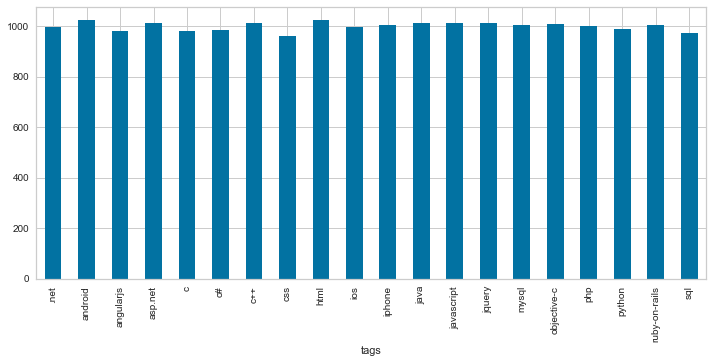

In [5]:
fig = plt.figure(figsize=(12,5))
df.groupby('tags').post.count().plot.bar(ylim=0)
plt.show();

The tags are evenly distributed.

### Check the Data

After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with our expectations. For example, print a few random samples to see if the label corresponds to the content of the post.

In [6]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [7]:
print_plot(250)

get session id from another table  i have 3 tables--answers  questions and tokens.    in <code>tokens</code> i have <code>id  token  created_at  updated_at</code>.    in <code>answers</code> i have <code>id  token (id)  text  created_at  updated_at</code>    in <code>questions</code> - <code>id  text</code>    how can i get id (from tokens)   i do this way:   <pre><code>result=answer.create(:question_id=&gt;question.id :token=&gt;session[:token] :text=&gt;params[ answer_ +question.id.to_s]) </code></pre>   i don t want <code>session[:token]</code>  it s pasted in table tokens (for example 23709274092107hdjshdsj) and i    <blockquote>    just need id!  </blockquote>
Tag: ruby-on-rails


In [8]:
print_plot(1000)

how to display this sql query as one table  very basic sql question. i wan t to display the output of the following query as one table instead of two:   <pre><code>select players.name from players inner join teams on players.team = teams.name where teams.staysat =  ambassador  and teams.checkin is not null;  select fans.name from fans where fans.staysat =  ambassador  and teams.checkin is not null; </code></pre>   how can a rewrite this so the players name and fans name are printed as one continuous list
Tag: sql


### Visualize Token (vocabulary) Frequency Distribution Before Text Preprocessing 

A frequency distribution tells us the frequency of each vocabulary item in the text.

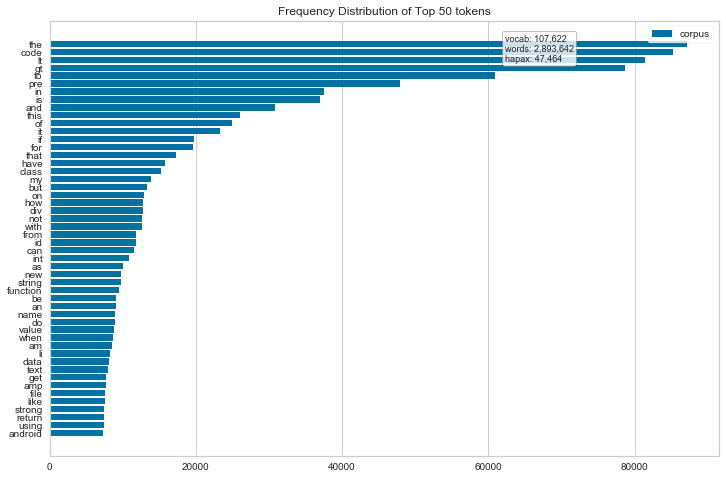

In [9]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['post'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Text Preprocessing

For this particular data set, our text cleaning includes the following steps:

* HTML decoding. The BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
* Remove stop words, 
* Change text to lower case 
* Remove punctuation 
* Remove bad characters 
and so on.

re.compile(), re.sub(), substitute the matched string with either " " or nothing.

Want to learn more on regular expression? https://www.youtube.com/watch?v=7DG3kCDx53c&list=PLRqwX-V7Uu6YEypLuls7iidwHMdCM6o2w

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [11]:
print_plot(250)

get session id another table 3 tablesanswers questions tokens codetokens code codeid token created_at updated_at code codeanswers code codeid token id text created_at updated_at code codequestions code codeid text code get id tokens way precoderesultanswercreate question_idgt questionid tokengt session token textgt params answer_ +questionidto_s code pre want codesession token code pasted table tokens example 23709274092107hdjshdsj blockquote need id blockquote
Tag: ruby-on-rails


In [12]:
print_plot(1000)

display sql query one table basic sql question wan display output following query one table instead two precodeselect playersname players inner join teams playersteam teamsname teamsstaysat ambassador teamscheckin null select fansname fans fansstaysat ambassador teamscheckin null code pre rewrite players name fans name printed one continuous list
Tag: sql


### Visualize Token Frequency Distribution After Text Preprocessing

It is interesting to compare the results of the frequency distribution before and after text preprocessing.

### Visually Compare the Differences in the Frequency Distributions for Two of the Tags: “sql” and “python”.

It is also interesting to explore the differences in tokens across different tags. Let’s visually compare the differences in the frequency distributions for two of the tags: "sql" and "python".

We are done text preprocessing!

## Feature extractions

A core step for a typical NLP component is to convert raw text into features, which give a machine learning model a simpler, more focused view of the text.

* We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1, 2, 3, ... 19.

* stratify=y will make sure that after random split, the classes are still balanced, in our case. 

In [13]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.tags.values)
X_train, X_test, y_train, y_test = train_test_split(df.post.values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.1)

### Tf-idf

term frequency–inverse document frequency 

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

Basically,  it is to scale down the impact of tokens that occur very frequently in every document, such as "a", "the".

TfidfVectorizer() Convert a collection of raw text or document to a matrix of Tf-idf features. And we will set important parameters.

* strip_accents='unicode', replace all accented unicode char by their corresponding ASCII char.
* analyzer='word',  feature made of words.
* token_pattern=r'\w{1,}', tokenize only words of 1+ chars.
* ngram_range=(1, 3), features made of unigram, bigram, and trigram.
* use_idf=True, Enable inverse-document-frequency reweighting.
* smooth_idf=True, prevents zero division for unseen words.
* sublinear_tf=True, Regularization technique that squishes the data to a lower, common magnitude -> 1 + log(tf).
* stop_words='english', Cleans the text for common, low-impact, filter words such as the, a, an, in ..etc, to make way for words that distinguish.

In [14]:
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

* binary=True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

In [15]:
target_names = lbl_enc.classes_

### Fitting Logistic Regression on Tf-idf

In [16]:
logregclf = LogisticRegression()
logregclf.fit(X_train_tfidf, y_train)
y_predtrain = logregclf.predict(X_train_tfidf)
print("Accuracy with logreg: {}".format(accuracy_score(y_train, y_predtrain)))
y_pred = logregclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

C:\Users\Sm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy with logreg: 0.9699444444444445
---Test Set Results---
Accuracy with logreg: 0.7975
               precision    recall  f1-score   support

         .net       0.63      0.67      0.65       100
      android       0.96      0.87      0.91       103
    angularjs       0.98      0.87      0.92        98
      asp.net       0.75      0.85      0.80       101
            c       0.82      0.82      0.82        98
           c#       0.62      0.65      0.63        99
          c++       0.86      0.69      0.77       102
          css       0.77      0.86      0.81        96
         html       0.69      0.75      0.72       102
          ios       0.64      0.65      0.64       100
       iphone       0.74      0.71      0.73       101
         java       0.90      0.80      0.85       101
   javascript       0.85      0.79      0.82       101
       jquery       0.94      0.79      0.86       101
        mysql       0.83      0.86      0.84       100
  objective-c       0.69  

### Fitting Naive Bayes on Tf-idf

In [17]:
NBclf = MultinomialNB()
NBclf.fit(X_train_tfidf, y_train)
y_pred = NBclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with NB: 0.7365
               precision    recall  f1-score   support

         .net       0.69      0.60      0.64       100
      android       0.88      0.83      0.85       103
    angularjs       0.91      0.90      0.90        98
      asp.net       0.71      0.69      0.70       101
            c       0.70      0.88      0.78        98
           c#       0.71      0.46      0.56        99
          c++       0.71      0.75      0.73       102
          css       0.66      0.83      0.74        96
         html       0.51      0.77      0.61       102
          ios       0.69      0.58      0.63       100
       iphone       0.75      0.63      0.69       101
         java       0.81      0.75      0.78       101
   javascript       0.88      0.60      0.72       101
       jquery       0.72      0.74      0.73       101
        mysql       0.61      0.92      0.73       100
  objective-c       0.68      0.69      0.69       101
          php   

### Fitting SVC (Support Vector Classifier) on Tf-idf

Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, note that before applying SVMs, we have to standardize the data.

In [18]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_tfidf)
X_train_svd = svd.transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.7765
               precision    recall  f1-score   support

         .net       0.54      0.74      0.62       100
      android       0.98      0.83      0.90       103
    angularjs       0.95      0.86      0.90        98
      asp.net       0.81      0.69      0.75       101
            c       0.82      0.81      0.81        98
           c#       0.50      0.70      0.58        99
          c++       0.80      0.70      0.74       102
          css       0.81      0.86      0.84        96
         html       0.70      0.70      0.70       102
          ios       0.56      0.67      0.61       100
       iphone       0.70      0.62      0.66       101
         java       0.85      0.80      0.83       101
   javascript       0.83      0.76      0.79       101
       jquery       0.91      0.76      0.83       101
        mysql       0.92      0.80      0.86       100
  objective-c       0.80      0.65      0.72

### Fitting SVC (Support Vector Classifier)  on BOW

### Fitting Random Forest on Tf-idf

In [19]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train_tfidf, y_train)
y_pred = RFclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

C:\Users\Sm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


---Test Set Results---
Accuracy with RF: 0.585
               precision    recall  f1-score   support

         .net       0.39      0.56      0.46       100
      android       0.78      0.73      0.75       103
    angularjs       0.71      0.66      0.68        98
      asp.net       0.44      0.67      0.53       101
            c       0.61      0.80      0.69        98
           c#       0.47      0.42      0.45        99
          c++       0.59      0.47      0.52       102
          css       0.49      0.74      0.59        96
         html       0.40      0.50      0.45       102
          ios       0.62      0.47      0.53       100
       iphone       0.50      0.56      0.53       101
         java       0.76      0.64      0.70       101
   javascript       0.59      0.52      0.55       101
       jquery       0.61      0.46      0.52       101
        mysql       0.60      0.69      0.64       100
  objective-c       0.60      0.50      0.55       101
          php    

### Fitting Xgboost on Tf-idf

We set n_jobs=-1 to use all of the CPU cores on our system, which is a good practice.

In [20]:
Xgbclf = xgb.XGBClassifier(n_jobs=-1)
Xgbclf.fit(X_train_tfidf.tocsc(), y_train)
y_pred = Xgbclf.predict(X_test_tfidf.tocsc())
print("---Test Set Results---")
print("Accuracy with Xgboost: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with Xgboost: 0.7875
               precision    recall  f1-score   support

         .net       0.62      0.70      0.66       100
      android       0.95      0.86      0.90       103
    angularjs       0.97      0.88      0.92        98
      asp.net       0.80      0.78      0.79       101
            c       0.80      0.80      0.80        98
           c#       0.54      0.71      0.61        99
          c++       0.82      0.66      0.73       102
          css       0.80      0.83      0.82        96
         html       0.68      0.73      0.70       102
          ios       0.65      0.66      0.66       100
       iphone       0.61      0.70      0.65       101
         java       0.94      0.81      0.87       101
   javascript       0.87      0.80      0.84       101
       jquery       0.88      0.83      0.86       101
        mysql       0.87      0.83      0.85       100
  objective-c       0.72      0.70      0.71       101
          p

### Misclassified:

In [21]:
for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
    if y != y_hat:
        print(f'post: {x} tag: {y} tag_pred: {y_hat}')

post: objc disable enable screen rotation work trying disable enable screen rotation viewcontrollers work get error use undeclared identifier shouldautorotatetointerfaceorientation using ios 8 miss precode bool shouldautorotatetointerfaceorientation uiinterfaceorientation interfaceorientation return interfaceorientation uiinterfaceorientationportrait code pre tag: objective-c tag_pred: ios
post: total number count string constant pool precodestring s1 + b string s2 new string code pre much researched think 2 ab two confusions ol liis b created constant pool li liwhen created concatenation creating new operator li ol tag: java tag_pred: c#
post: oitcontrol zoom code precodecontrols new threeorbitcontrols camera controlsaddeventlistener change render code pre live preview href http jsfiddlenet user1 mqmtx1 rel nofollow misc_control_orbit_demo see error console zoom someone show wrong thanks tag: javascript tag_pred: c#
post: resolve fixed div positions html would like know divs fixed pas

### Next Steps

* More text preprocessing, such as stemming and lemmatization
* Tune LogReg Hyperparameters, such as try different values of C with l1 and l2 penalty. 
* Try Doc2vec, which is sibling of Word2vec.
* Try Xgboost. If things don’t go your way in predictive modeling, try Xgboost.
* Gather more training data.

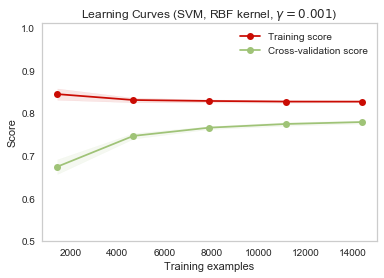

In [22]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
X, y = X_train_svd_scale, y_train
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=4)
plt.show();

Cross-validation score (green line) increases gradually.

* able to learn from data
* Still low scores (high errors)

Should tweak model (perhaps increase model complexity), more feature engineering, more data.